# Rock Paper Scissors Image Classification Submission for Dicoding

## Using CNN 
## Using Callbacks for early stopping
## Tried to Use Batchnormalization but validation score fell and resulted in overfitting, cancel batchnormalization usage

In [1]:
#install required library first
!pip install split_folders tqdm #for dataset train test split 
!pip install seedir #for directory treeview 

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
import zipfile,os
import splitfolders #for easier dataset splitting  
import seedir as sd #for directory tree viewer
import pandas as pd
import timeit #for calculating script runtime
start = timeit.default_timer()

In [3]:
# Fetching the dataset
!wget --no-check-certificate \
    https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
    -O /tmp/rockpaperscissors.zip

--2021-06-22 00:47:37--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  4.22MB/s    in 83s     

2021-06-22 00:49:00 (3.71 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [4]:
#extract and put into temporary folder
dataset = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(dataset, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [5]:
#target directory
target_dir = '/tmp/rockpaperscissors/rps-cv-images/'

In [6]:
#check dataset directory
sd.seedir(target_dir, style='lines', itemlimit=3, depthlimit=2)

rps-cv-images/
├─scissors/
│ ├─GIFgGPzv7MykUgzM.png
│ ├─P2mN2BN7A8eaYm1l.png
│ └─8Q1PAZsxpLf5FAo6.png
├─rock/
│ ├─RpCSMPJ0LhFPYksZ.png
│ ├─nY37eRslka1ss2bZ.png
│ └─l0rOvSD1UwFg1Xv2.png
└─paper/
  ├─HbBcQItQ6d5yMDqL.png
  ├─Z9vSGzBQ8YLOXQIX.png
  └─axwcCc4rC8ySUtML.png


In [7]:
#split files into respective Train and Val directory using splitfolders lib
#60:40 split ratio (Dicoding reqwirements)
splitfolders.ratio(target_dir, 
                   output= '/tmp/rockpaperscissors/rps-cv-images/split_dataset',
                   seed=42, 
                   ratio=(0.6,0.4), 
                   group_prefix=None)

Copying files: 2188 files [00:00, 3214.11 files/s]


In [8]:
#result after splitting 
sd.seedir('/tmp/rockpaperscissors/rps-cv-images/split_dataset', 
          style='lines', itemlimit=3, depthlimit=2)

split_dataset/
├─val/
│ ├─scissors/
│ ├─rock/
│ └─paper/
└─train/
  ├─scissors/
  ├─rock/
  └─paper/


### Count the total files in the dataset pre and post split

In [9]:
#count total files inside original dataset, and total files after train and validation set split
split_path = '/tmp/rockpaperscissors/rps-cv-images/split_dataset/'
folder_names = ['paper', 'rock', 'scissors']

original_files ={}
train_files = {}
val_files = {}

for i in folder_names:
    original_files[i] = len(os.listdir(target_dir+i))
    train_files[i] = len(os.listdir(split_path+'train/'+i))
    val_files[i] = len(os.listdir(split_path+'val/'+i))

    
#convert to dataframe for easier comprehension
result_split = pd.DataFrame()
result_split = result_split.append(original_files, ignore_index=True)
result_split = result_split.append(train_files, ignore_index=True)
result_split = result_split.append(val_files, ignore_index=True)
result_split['total'] = result_split.sum(axis=1)
result_split['type'] = ['original', 'train', 'val']
result_split = result_split[['type', 'paper', 'rock', 'scissors', 'total']]
print(result_split)

       type  paper   rock  scissors   total
0  original  712.0  726.0     750.0  2188.0
1     train  427.0  435.0     450.0  1312.0
2       val  285.0  291.0     300.0   876.0


In [10]:
## saving train and validation path into variable
train_set = '/tmp/rockpaperscissors/rps-cv-images/split_dataset/train'
val_set = '/tmp/rockpaperscissors/rps-cv-images/split_dataset/val'

In [11]:
#image augmentation
train_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    vertical_flip = True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

valid_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    vertical_flip = True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [12]:
#train and validation data generator
#image resize to 128x128
#batch size 64
#class mode is categorical since we have 3 classes
train_generator = train_aug.flow_from_directory(
        train_set,  
        target_size=(128, 128),  
        batch_size=64,
        class_mode='categorical')

validation_generator = valid_aug.flow_from_directory(
        val_set, 
        target_size=(128, 128), 
        batch_size=64, 
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


## Build  conVnet Model

In [13]:
#building model 
#using 1 hidden layer 
#using softmax in output layer instead of sigmoid because there are 3 outcomes (paper, rock, or scissors)
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (128,128,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation= 'relu'),
    layers.Dense(3, activation= 'softmax')
])

In [14]:
# Adding lose function and optimizer
#categorical since we have 3 classes
#using adam 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# Add early stop to prevent overfitting
minimum_change = 0.01 #minimum change to be considered an improvement
epoch_stop = 5 #number of epoch to wait before stopping
early_stop = EarlyStopping(
    min_delta = minimum_change, 
    patience= epoch_stop, 
    restore_best_weights=True,
)

In [16]:
# Training the model
history = model.fit(
    train_generator,
    epochs=30, 
    steps_per_epoch=15,
    validation_data = validation_generator,
    verbose = 1,
    validation_steps=3,
    callbacks=[early_stop],
)

Epoch 1/30
15/15 [==============================] - 36s 2s/step - loss: 1.1474 - accuracy: 0.3922 - val_loss: 1.0316 - val_accuracy: 0.4427
Epoch 2/30
15/15 [==============================] - 34s 2s/step - loss: 0.8772 - accuracy: 0.6099 - val_loss: 0.6928 - val_accuracy: 0.7188
Epoch 3/30
15/15 [==============================] - 34s 2s/step - loss: 0.5695 - accuracy: 0.7920 - val_loss: 0.5563 - val_accuracy: 0.7760
Epoch 4/30
15/15 [==============================] - 34s 2s/step - loss: 0.4861 - accuracy: 0.8168 - val_loss: 0.4174 - val_accuracy: 0.8854
Epoch 5/30
15/15 [==============================] - 34s 2s/step - loss: 0.3725 - accuracy: 0.8772 - val_loss: 0.4150 - val_accuracy: 0.8177
Epoch 6/30
15/15 [==============================] - 35s 2s/step - loss: 0.2953 - accuracy: 0.9042 - val_loss: 0.2387 - val_accuracy: 0.9062
Epoch 7/30
15/15 [==============================] - 35s 2s/step - loss: 0.3277 - accuracy: 0.8708 - val_loss: 0.1767 - val_accuracy: 0.9375
Epoch 8/30
15/15 [==

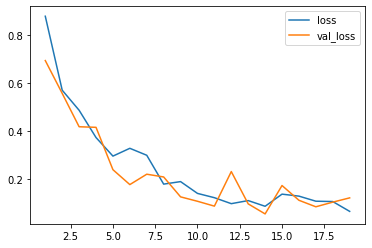

In [17]:
#loss 
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
plt.show()

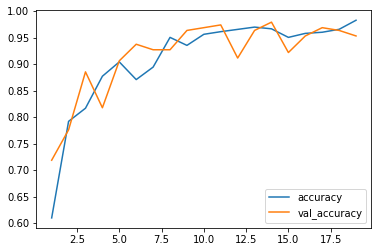

In [18]:
#accuracy 
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [25]:
#Best validation loss and accuracy score
print(("Best Validation Loss: {:0.2f}" +"\nBest Validation Accuracy: {:0.2f}").format(history_df['val_loss'].min(), history_df['val_accuracy'].max()))

Best Validation Loss: 0.05
Best Validation Accuracy: 0.98


Saving 3hIcgfPOoWEIs16j.png to 3hIcgfPOoWEIs16j (2).png
3hIcgfPOoWEIs16j.png
Scissors


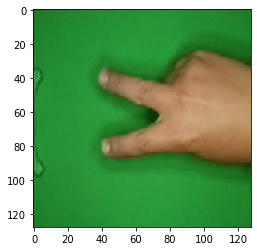

In [24]:
upload_file = files.upload()
 
for file_name in upload_file.keys():
 
  # predicting images
  file_path = file_name
  img = image.load_img(files_path, target_size=(128,128))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  predict = model.predict(images, batch_size=10)
  print(file_name)
  if predict[0][0] == 1.:
    print('Paper')
  elif predict[0][1] == 1.:
    print('Rock')
  else:
    print('Scissors')


In [21]:
stop = timeit.default_timer()

print('Running Time: ', stop - start)  #find the total running time

Running Time:  1000.3123539440003
